<a href="https://colab.research.google.com/github/mauricef/mauricef.github.io/blob/main/jax-ml/differentiable_finite_state_machines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Differentiable Finite State Machines
This notebook is based off of a [blog post](https://google-research.github.io/self-organising-systems/2022/diff-fsm/) by Alexander Mordvintsev with some modifications.

- Generate random sparse models instead of hand picked models
- Generate random samples from the sparse model for training instead of training
on the same input / output sequence
- Support for more than two input and output classes
- Softmax loss instead of squared error.


## Imports

In [ ]:
!pip install -q optax

     |████████████████████████████████| 140 kB 15.4 MB/s 
     |████████████████████████████████| 72 kB 784 kB/s 


In [ ]:
from collections import namedtuple
from functools import partial
from typing import NamedTuple, Any
import jax
import jax.numpy as jp
from jax.scipy.special import entr, logit
from jax import jit, nn, random, lax, tree_map, grad, vmap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import optax
from optax import softmax_cross_entropy
rng = random.PRNGKey(42)

## Utilities

In [ ]:
def str_to_onh(s, num_classes):
    oh = jp.array(list(map(int, s)))
    oh = nn.one_hot(oh, num_classes=num_classes)
    return oh

def onh_to_str(oh):
    s = jp.argmax(oh, axis=1)
    s = ''.join(list(map(str, s)))
    return s

@jit
def hardmax(x):
    return nn.one_hot(jp.argmax(x, -1), x.shape[-1])

## Data Generating Process

In [ ]:
class FSMShape(NamedTuple):
    x_size: int
    s_size: int
    y_size: int

    @property
    def s_shape(self):
        return (self.s_size,)
        
    @property
    def t_shape(self):
        return (self.x_size, self.s_size, self.s_size)

    @property
    def r_shape(self):
        return (self.x_size, self.s_size, self.y_size)

In [ ]:
class FSM(NamedTuple):
    s0: Any
    t : Any 
    r : Any

    @property
    def s_size(self):
        return self.t.shape[1]

In [ ]:
@partial(jit, static_argnums=1)
def init_random_sparse_fsm(rng, fsm_shape, temperature=100.):
    r1, r2 = random.split(rng)
    t = random.randint(
        r1, minval=0, maxval=fsm_shape.s_size, 
        shape=(fsm_shape.x_size, fsm_shape.s_size))
    r = random.randint(
        r2, minval=0, maxval=fsm_shape.y_size,
        shape=(fsm_shape.x_size, fsm_shape.s_size))
    fsm = FSM(
        s0=nn.one_hot(0, num_classes=fsm_shape.s_size),
        t=nn.one_hot(t, num_classes=fsm_shape.s_size),
        r=nn.one_hot(r, num_classes=fsm_shape.y_size)
    )
    # the fsm parameters are logits not probabilities multiply by
    # temperature to ensure the resulting softmax probabilities are close to 1. / 0.
    return tree_map(lambda a: a * temperature, fsm)

In [ ]:
@jit
def predict(model_state, x):
    model_state = tree_map(partial(nn.softmax, axis=-1), model_state)

    def step(s, x):
        y = jp.einsum('x,s,xsy->y', x, s, model_state.r)
        s1 = jp.einsum('x,s,xst->t', x, s, model_state.t)
        return s1, (s, y)

    s0 = model_state.s0
    _, (s, y) = lax.scan(step, s0, x)
    return s, y

In [ ]:
@partial(jit, static_argnums=1)
def init_random_dense_fsm(rng, fsm_shape):
    r1, r2, r3 = random.split(rng, 3)
    s0 = random.normal(r1, fsm_shape.s_shape)
    T = random.normal(r2, fsm_shape.t_shape)
    R = random.normal(r3, fsm_shape.r_shape)
    return FSM(s0, T, R)

## Learning

In [ ]:
def prediction_loss(y, yp):
    return softmax_cross_entropy(logit(yp), y).mean()

def entropy_loss(s):
    s = jp.mean(s, axis=0)
    return entr(s).mean()

def loss_f(model_state, x, y, entropy_loss_weight=.25):
    sp, yp = predict(model_state, x)
    return prediction_loss(y, yp) + entropy_loss(sp) * entropy_loss_weight

In [ ]:
@partial(jit, static_argnums=1)
def train_step(model_state, optimizer, opt_state, xs, ys):
    def mean_batch_loss(model_state):
        losses = vmap(partial(loss_f, model_state=model_state))(x=xs, y=ys)
        return losses.mean()
    grads = grad(mean_batch_loss)(model_state)
    updates, opt_state = optimizer.update(grads, opt_state)
    model_state = optax.apply_updates(model_state, updates)
    return (model_state, opt_state)

In [ ]:
@partial(jit, static_argnums=(4, 5))
def train(model_state, opt_state, xs, ys, optimizer, steps):
    def step(training_state, _):
        model_state, opt_state = training_state
        model_state, opt_state = train_step(model_state, optimizer, opt_state, xs, ys)
        return (model_state, opt_state), model_state
    _, model_states = lax.scan(step, init=(model_state, opt_state), xs=None, length=steps)
    return model_states

In [ ]:
@jit
def distinct_state_count(s):
    s = jp.argmax(s, axis=-1)
    s = jp.ravel(s)
    values = jp.unique(s, size=s.shape[0], fill_value=-1)
    return jp.sum(values != -1)

In [ ]:
@jit
def accuracy(y, yp):
    return jp.mean(np.argmax(y, axis=-1) == jp.argmax(yp, axis=-1))

In [ ]:
@jit
def evaluate_model_state(model_state, x, y):
    sp, yp = fsm_rollout(model_state, x)
    return {
        #'prediction_loss': prediction_loss(y, yp),
        # 'entropy_loss': entropy_loss(sp),
        'accuracy': accuracy(y, yp),
        'distinct_state_count': distinct_state_count(sp)
    }

In [ ]:
@jit
def evaluate_trial(model_states, xs, ys):
    def evaluate_batch(model_state):
        results = vmap(partial(evaluate_model_state, model_state=model_state))(x=xs, y=ys)
        results = tree_map(lambda a: a.mean(-1), results)
        return results
    return vmap(evaluate_batch)(model_states)

In [ ]:
def plot_results(results, generative_s_size, inference_s_size):
    df = pd.DataFrame(data=results)
    fig, ax1 = plt.subplots(figsize=(10, 10))
    ax1.set_xlabel('step')
    ax1.set_ylim(0, 1.1)
    ax1.set_ylabel('accuracy %', color='blue')
    ax1.plot(df.accuracy, color='blue')
    ax2 = ax1.twinx()
    ax2.hlines(
        y=generative_s_size, 
        xmin=0, xmax=len(df.index), colors='aqua', label='Generative State Count')
    ax2.set_ylim(0, max(generative_s_size, inference_s_size) + 1)
    ax2.set_ylabel('state count', color='red')
    ax2.plot(df.distinct_state_count, color='red')

In [ ]:
@partial(jit, static_argnames=('fsm_shape', 'episode_length'))
def sample(rng, fsm, fsm_shape, episode_length):
    rng, r = random.split(rng)
    x = random.randint(r, minval=0, maxval=2, shape=(episode_length,))
    x = nn.one_hot(x, num_classes=fsm_shape.x_size)
    s, y = predict(fsm, x)
    return x, s, y

@partial(jit, static_argnums=(2, 3, 4))
def sample_batch(rng, fsm, fsm_shape, episode_length, batch_size):
    rngs = random.split(rng, batch_size)
    rngs = jp.array(rngs)
    _sample = partial(sample, fsm=fsm, fsm_shape=fsm_shape, episode_length=episode_length)
    return vmap(_sample)(rng=rngs)

In [ ]:
x_size = 4
y_size = 4
generative_s_size = 25
inference_s_size = 100
trials = 100
steps = 400
training_batch_size = 256
evaluation_batch_size = 256
episode_length = 40

In [ ]:
generative_fsm_shape = FSMShape(x_size=x_size, s_size=generative_s_size, y_size=y_size)
rng, r = random.split(rng)
generative_fsm = init_random_sparse_fsm(r, generative_fsm_shape)
rng, r = random.split(rng)
xs, ss, ys = sample_batch(r, generative_fsm, generative_fsm_shape, episode_length, 1024)
distinct_state_count(ss)

DeviceArray(19, dtype=int32)

In [ ]:
rng, r = random.split(rng)
inference_fsm_shape = FSMShape(x_size=x_size, s_size=inference_s_size, y_size=y_size)
model_state = init_random_dense_fsm(r, inference_fsm_shape)
optimizer = optax.adam(learning_rate=.1)
opt_state = optimizer.init(model_state)
rng, r = random.split(rng)
xs, ss, ys = sample_batch(r, generative_fsm, generative_fsm_shape, episode_length, training_batch_size)
rng, r = random.split(rng)
model_states = train(
    model_state = model_state,
    opt_state = opt_state,
    xs = xs, ys = ys,
    optimizer = optimizer,
    steps = steps
)

19


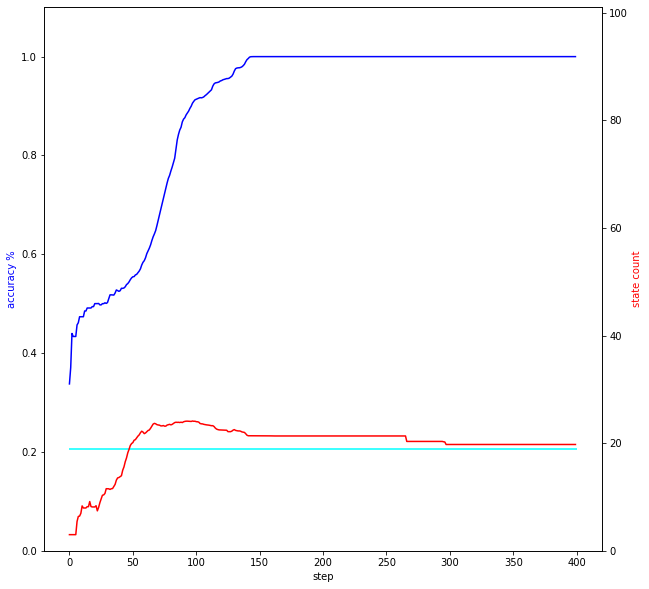

In [ ]:
rng, r = random.split(rng)
xs, ss, ys = sample_batch(r, generative_fsm, generative_fsm_shape, episode_length, evaluation_batch_size)
results = evaluate_trial(
    model_states = model_states,
    xs = xs, ys = ys
)
print(distinct_state_count(ss))
plot_results(
    results = results,
    generative_s_size = distinct_state_count(ss),
    inference_s_size = inference_s_size
)